In [3]:
from scipy.stats import poisson,skellam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests as rs
sns.set_style(style="darkgrid")
import random

## Get stats (Goals/Goals Against/Points)

In [4]:
def get_goals():
    ##Import matches from OpenLigaDB
    url = "https://www.openligadb.de/api/getmatchdata/bl3/2018"
    games = rs.get(url).content

    import json
    games=json.loads(games)
    
    #Define variables
    home_team=[]
    away_team=[]
    home_goals=[]
    away_goals=[]
    home_points=[]
    away_points=[]

    #Loops trough each games and gets Teams and Scores
    for each in games:
        home_team.append(each["Team1"]["TeamName"])
        away_team.append(each["Team2"]["TeamName"])
        try:
            home_goals.append(each["MatchResults"][1]["PointsTeam1"])
            away_goals.append(each["MatchResults"][1]["PointsTeam2"])
        except:
            home_goals.append(None)
            away_goals.append(None)
        try:
            if each["MatchResults"][1]["PointsTeam1"]>each["MatchResults"][1]["PointsTeam2"]:
                home_points.append(3)
                away_points.append(0)
            elif each["MatchResults"][1]["PointsTeam1"]<each["MatchResults"][1]["PointsTeam2"]:
                home_points.append(0)
                away_points.append(3)
            elif each["MatchResults"][1]["PointsTeam1"]==each["MatchResults"][1]["PointsTeam2"]:
                home_points.append(1)
                away_points.append(1)
            else:
                home_points.append(1)
                away_points.append(1)
        except:
                home_points.append(None)
                away_points.append(None)
    
    #Create DataFrame with Teams and scores
    dic={"Home Team":home_team,"Away Team":away_team,"Home Goals":home_goals,"Away Goals":away_goals, "Home Points":home_points, "Away Points":away_points}
    df=pd.DataFrame(dic)
    df.dropna(inplace=True)

    #Create average home and away goals 
    #away_average_goals=df.pivot_table(index="Away Team",values="Away Goals",aggfunc=np.mean)
    #home_average_goals=df.pivot_table(index="Home Team",values="Home Goals",aggfunc=np.mean)
    
    return games, df

### Pivot Goals Frame

In [5]:
def create_stats(df):
    #Create Goal/Goals against per Team
    home = df.pivot_table(index="Home Team", values=["Home Goals","Away Goals"])
    home.rename(columns={"Away Goals":"Home conceded","Home Goals":"Home scored"}, inplace=True)
    away = df.pivot_table(index="Away Team", values=["Away Goals","Home Goals"])
    away.rename(columns={"Away Goals":"Away scored","Home Goals":"Away conceded"}, inplace=True)

    #Caculate means
    avg_home=df["Home Goals"].mean()
    avg_away=df["Away Goals"].mean()

    #Caclulate Strenghts
    home["Attack"]= home["Home scored"]/avg_home
    home["Defence"]=home["Home conceded"]/avg_away
    away["Attack"]=away["Away scored"]/avg_away
    away["Defence"]=away["Away conceded"]/avg_home
    
    return home, away, avg_home, avg_away

## Predict results

### Convert goals to predictions

In [21]:
def predict_match(home_team,away_team,home_stats, away_stats, avg_home, avg_away):
    team_home={}
    team_away={}
        
    #Calculating Strengt
    mu_home=avg_home*home_stats["Attack"][home_team]*away_stats["Defence"][away_team]
    mu_away=avg_away*away_stats["Attack"][away_team]*home_stats["Defence"][home_team]
        
    #Determines how many goals should be considered
    team_home[5]=1
    team_away[5]=1
    
    for i in np.arange(0,5):  
        team_home[i]=poisson.pmf(k=i,mu=mu_home)
        team_away[i]=poisson.pmf(k=i,mu=mu_away)
        #fill probability
        team_home[5]=team_home[5]-team_home[i]
        team_away[5]=team_away[5]-team_away[i]
        
    a=pd.Series(team_home)
    b=pd.Series(team_away)                  
    cols = ['Home Goals', 'Away Goals', 'Probability']
    lst=[]
    
    #Calculate outcome
    random1=random.randint(0,101)/100
    
    step=a[0]
    i=0
    
    while random1>step:
        prob=a[i]
        step=step+prob
        i=i+1
    
    score_home=i
    
    step=b[0]
    i=0
    
    while random1>step:
        prob=b[i]
        step=step+prob
        i=i+1
    
    score_away=i
    
    return score_home, score_away
    ##return score_home, score_away

In [7]:
def upcoming_games(data):
    home_team=[]
    away_team=[]

    for each in data:
        if each["MatchIsFinished"]==False:
            home_team.append(each["Team1"]["TeamName"])
            away_team.append(each["Team2"]["TeamName"])

    games={"Home Team":home_team,"Away Team":away_team} 
    
    return games

In [8]:
def play_shedule(shedule, home_stats, away_stats, avg_home, avg_away):
    #Calculate number of games
    number_games=len(shedule["Away Team"])
    
    home_score=[]
    away_score=[]
    
    for each in range(0,number_games):
        score_home, score_away=predict_match(shedule["Home Team"][each],shedule["Away Team"][each],home_stats, away_stats, avg_home, avg_away) 
        home_score.append(score_home)
        away_score.append(score_away)
    
    dic = {"Home Team":shedule["Home Team"], "Away Team": shedule["Away Team"],"Home Goals": home_score, "Away Goals": away_score}
    df=pd.DataFrame(dic)
    
    return df

In [9]:
def create_table(played, results):
    home_points=[]
    away_points=[]
    
    def points(each):
        if each["Home Goals"]>each["Away Goals"]:
            home_points.append(3)
            away_points.append(0)
        elif each["Home Goals"]<each["Away Goals"]:
            home_points.append(0)
            away_points.append(3)
        elif each["Home Goals"]==each["Away Goals"]:
            home_points.append(1)
            away_points.append(1)
    
    results.apply(points, axis=1)
    
    results["Home Points"]=home_points
    results["Away Points"]=away_points
    
    total_games = pd.concat([played,results],axis=0)
    
    home = total_games.pivot_table(index="Home Team", values=["Home Goals","Home Points", "Away Goals"], aggfunc=np.sum)
    home.rename(columns={"Away Goals":"Goals Against","Home Goals":"Goals","Home Points":"Points"}, inplace=True)
    away = total_games.pivot_table(index="Away Team", values=["Away Goals","Away Points", "Home Goals"], aggfunc=np.sum)
    away.rename(columns={"Home Goals":"Goals Against","Away Goals":"Goals","Away Points":"Points"}, inplace=True)
    total=home+away
    total=total.sort_values(by="Points", ascending=False).reset_index()
    
    return total

In [10]:
def simulate_season():
    #Collect the data
    games, df = get_goals()
    home_stats, away_stats, avg_home, avg_away = create_stats(df)
    shedule=upcoming_games(games)
    
    #Simulate Seasons
    rank_teams={}
    points_teams={}
    
    for each in home_stats.index.values:
        rank_teams[each]=[]
        points_teams[each]=[]
    
    for i in range(0,10000):
        results=play_shedule(shedule, home_stats, away_stats, avg_home, avg_away)
        total_games=create_table(df, results)
        total_games["Rank"]=total_games.index+1
        total_games.set_index("Home Team",inplace=True)
        for each in home_stats.index.values:
            rank_teams[each].append(total_games["Rank"][each])
            points_teams[each].append(total_games["Points"][each])
    return rank_teams, points_teams
    #return home_stats

In [15]:
ranks, points=simulate_season()

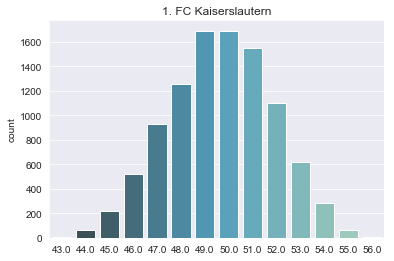

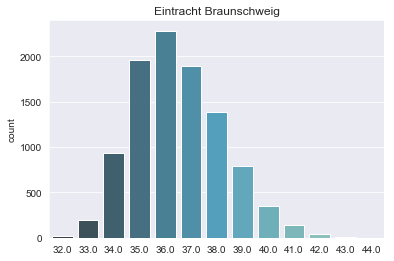

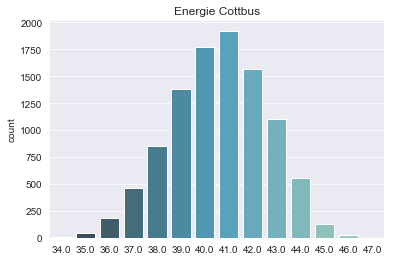

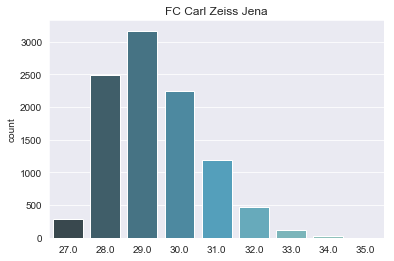

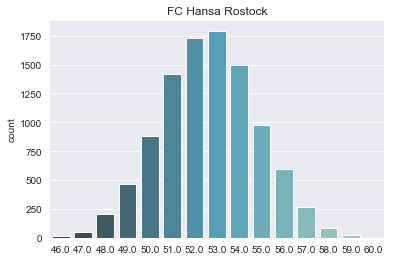

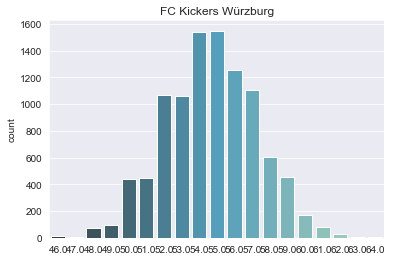

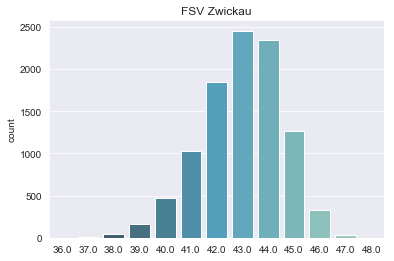

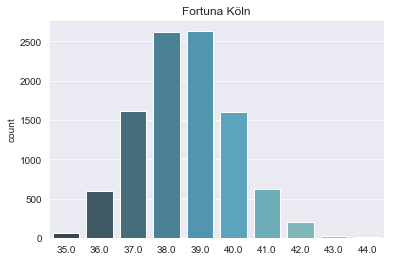

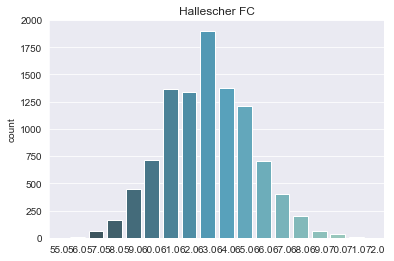

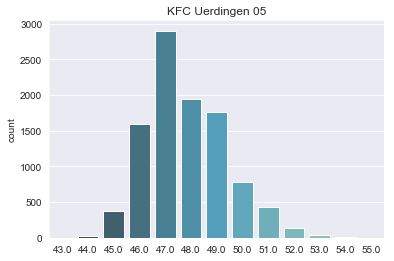

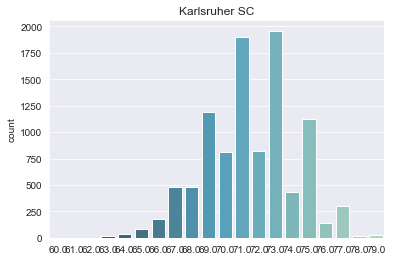

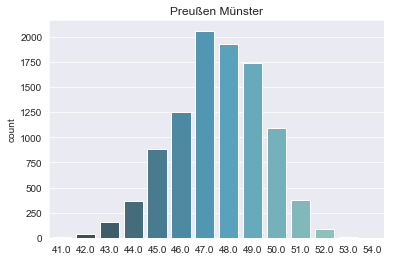

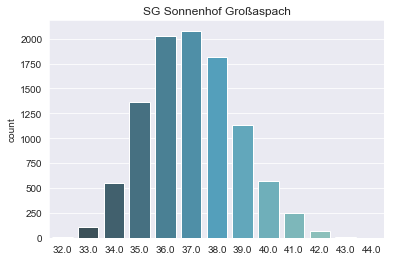

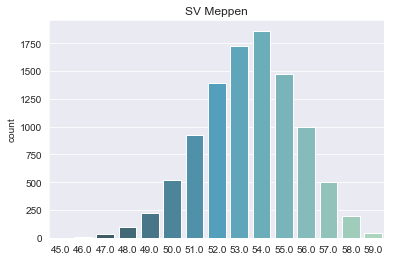

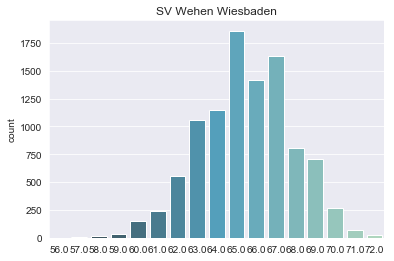

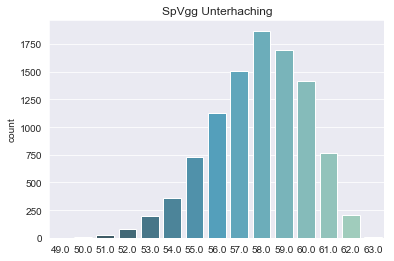

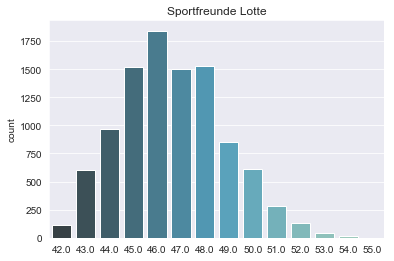

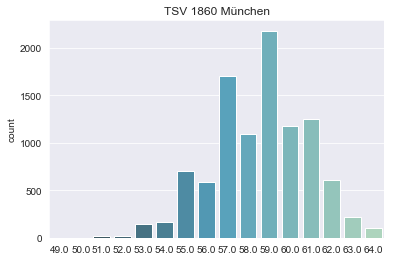

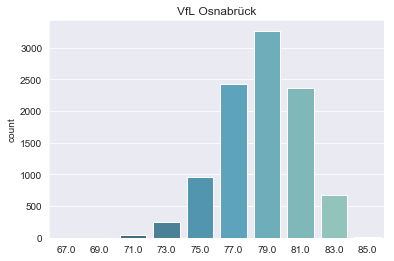

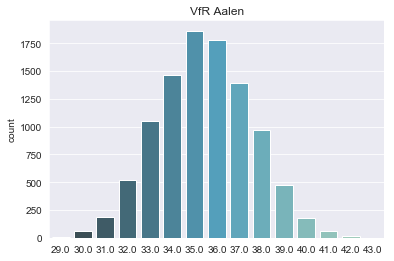

In [17]:
for key, value in points.items():
    plt.figure()
    sns.countplot(value,palette="GnBu_d")
    plt.title(key)

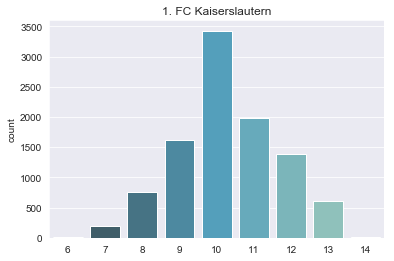

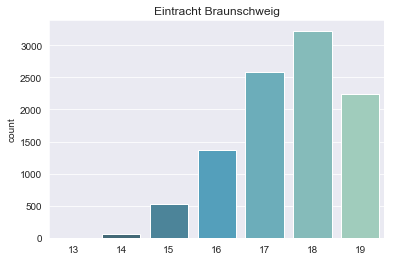

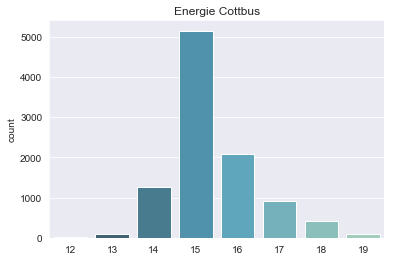

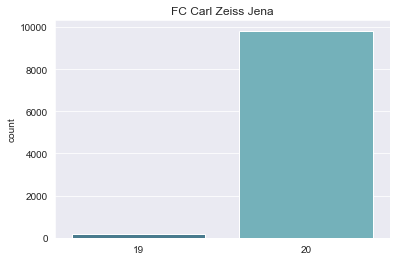

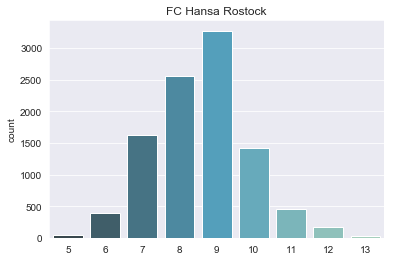

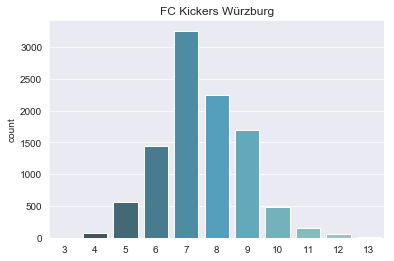

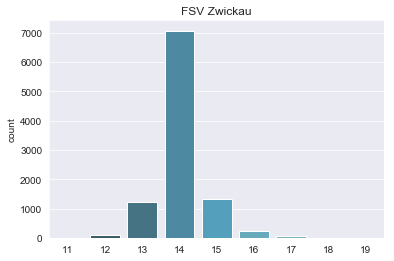

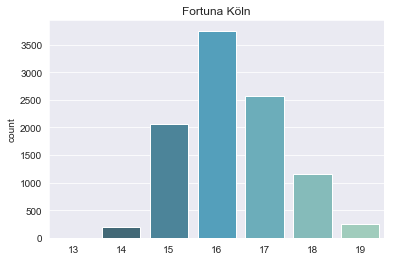

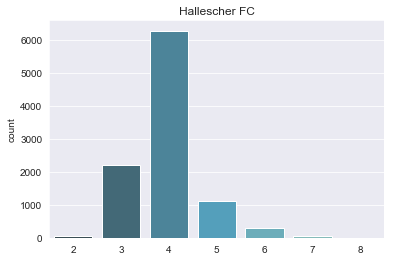

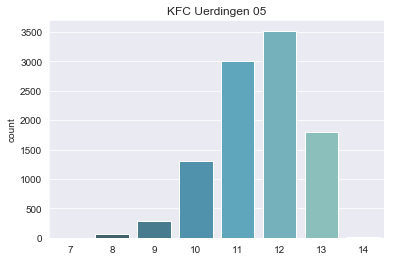

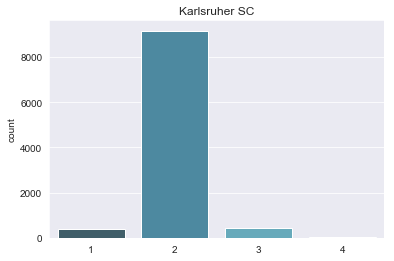

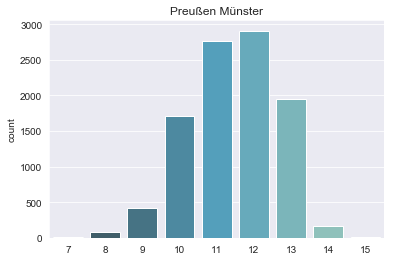

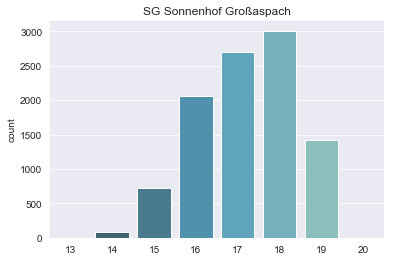

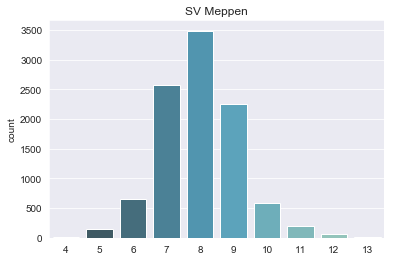

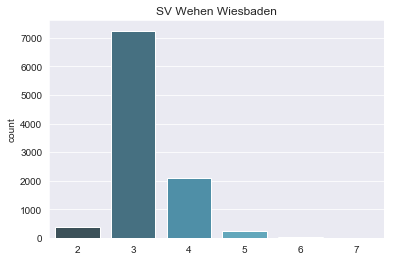

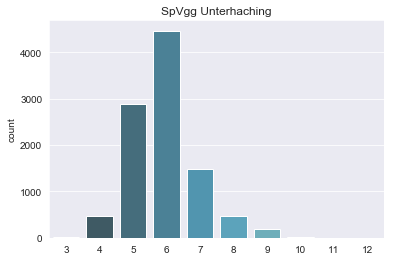

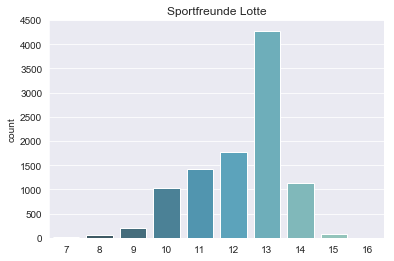

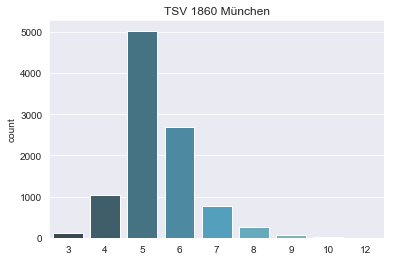

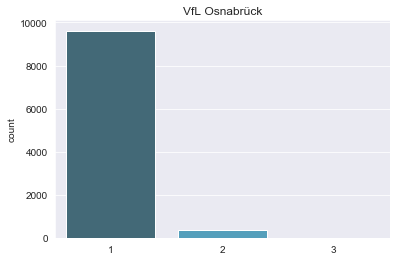

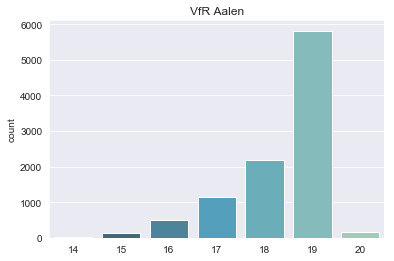

In [41]:
for key, value in ranks.items():
    a=plt.figure()
    sns.countplot(value,palette="GnBu_d")
    plt.title(key)